# Comparison of K-Means and DBSCAN Clustering in Python

https://elitedatascience.com/machine-learning-algorithms

#### K-Means:
    Strengths: K-Means is hands-down the most popular clustering algorithm because it's fast, simple, and surprisingly flexible if you pre-process your data and engineer useful features.
    Weaknesses: The user must specify the number of clusters, which won't always be easy to do. In addition, if the true underlying clusters in your data are not globular, then K-Means will produce poor clusters.

https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e
    
    K-means performs poorly because the underlying assumptions on the shape of the clusters are not met; it is a parametric algorithm parameterized by the K cluster centroids, the centers of gaussian spheres. 

#### DBSCAN:
    Strengths: DBSCAN does not assume globular clusters, and its performance is scalable. In addition, it doesn't require every point to be assigned to a cluster, reducing the noise of the clusters (this may be a weakness, depending on your use case).
    Weaknesses: The user must tune the hyperparameters 'epsilon' and 'min_samples,' which define the density of clusters. DBSCAN is quite sensitive to these hyperparameters.

https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/
    
    The most exciting feature of DBSCAN clustering is that it is robust to outliers. It also does not require the number of clusters to be told beforehand, unlike K-Means, where we have to specify the number of centroids.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# clear variables
from IPython import get_ipython
get_ipython().magic('reset -sf')

#1 Importing the libraries
import numpy as np
import pandas as pd
# import pyreadstat                        # conda install -c conda-forge pyreadstat
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


#from scipy import stats as stats


from scipy.stats import norm, skew 

import sys
!{sys.executable} -m pip install kneed
from kneed import KneeLocator             # conda install -c conda-forge kneed

from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


In [75]:
#2 Importing the dataset
url = "https://raw.githubusercontent.com/ShubhankarRawat/Mall-Customers-Segmentation/master/data.csv"
data = pd.read_csv(url, index_col= None, na_values='?')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [77]:
#Looking for null values
data.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [78]:
#Changing the name of some columns
data = data.rename(columns={'Annual Income (k$)': 'Annual_income', 'Spending Score (1-100)': 'Spending_score'})
data.head()

,CustomerID,Gender,Age,Annual_income,Spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [79]:
df = data.copy()
#Replacing objects for numerical values
df['Gender'].replace(['Female','Male'], [0,1],inplace=True)
df.head()

,CustomerID,Gender,Age,Annual_income,Spending_score
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


In [80]:
# Display a description of the dataset
stats = df.describe()
stats

,CustomerID,Gender,Age,Annual_income,Spending_score
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,0.440000,38.850000,60.560000,50.200000
std,57.879185,0.497633,13.969007,26.264721,25.823522
min,1.000000,0.000000,18.000000,15.000000,1.000000
25%,50.750000,0.000000,28.750000,41.500000,34.750000
50%,100.500000,0.000000,36.000000,61.500000,50.000000
75%,150.250000,1.000000,49.000000,78.000000,73.000000
max,200.000000,1.000000,70.000000,137.000000,99.000000


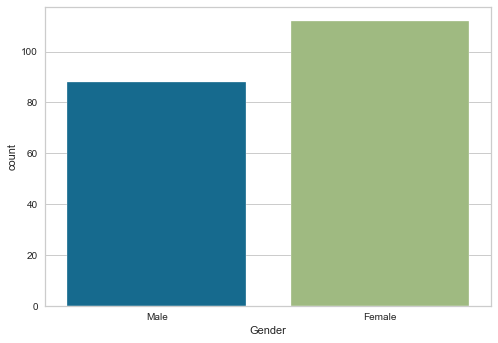

In [81]:
sns.countplot(data['Gender'],data = df)
plt.show()

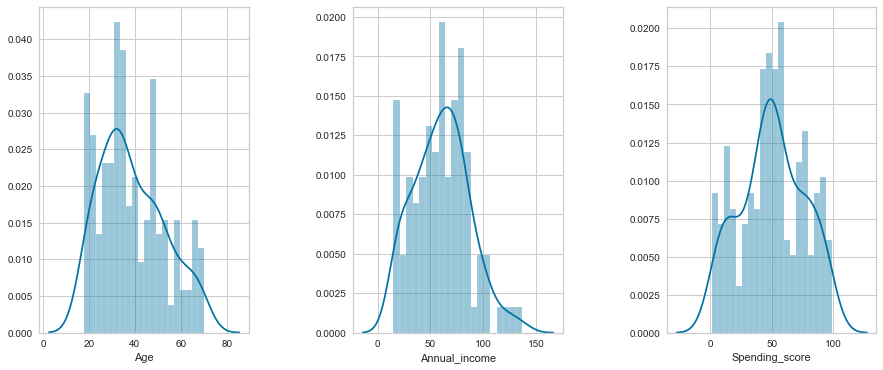

In [82]:
# https://datauab.github.io/mall_segmentation/
# Density estimation of values using distplot
plt.figure(1 , figsize = (15 , 6))
feature_list = ['Age','Annual_income', "Spending_score"]

pos = 1 
for i in feature_list:
    plt.subplot(1 , 3 , pos)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(df[i], bins=20, kde = True)
    pos = pos + 1
plt.show()

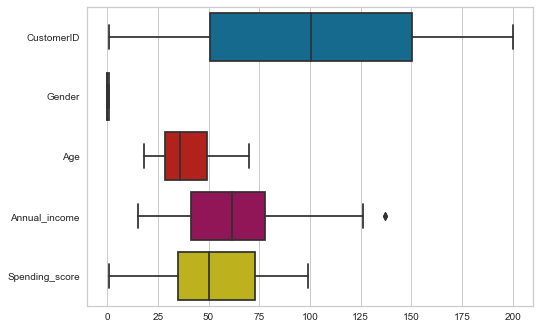

In [83]:
sns.boxplot(data= df,  orient="h")

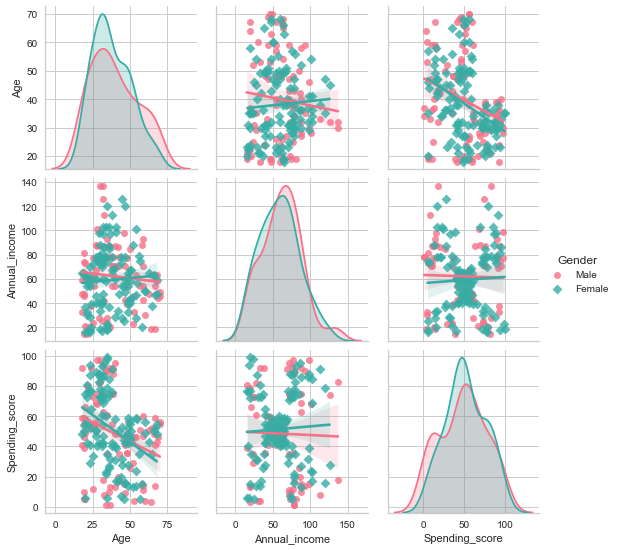

In [84]:
sns.pairplot(data, vars=["Age", "Annual_income", "Spending_score"],  kind ="reg", hue = "Gender", palette="husl", markers = ['o','D'])


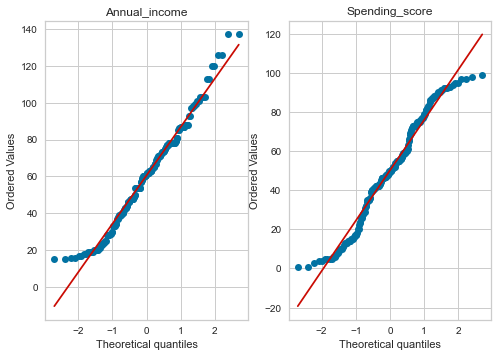

In [85]:
# QQ-plot
from scipy import stats as stats

fig = plt.figure()
ax = fig.add_subplot(121)
res =stats.probplot(df['Annual_income'], plot=plt)
ax.set_title('Annual_income') 

ax = fig.add_subplot(122)
res = stats.probplot(df['Spending_score'], plot=plt)
ax.set_title('Spending_score') 
plt.show()

### Kmeans Algorithm

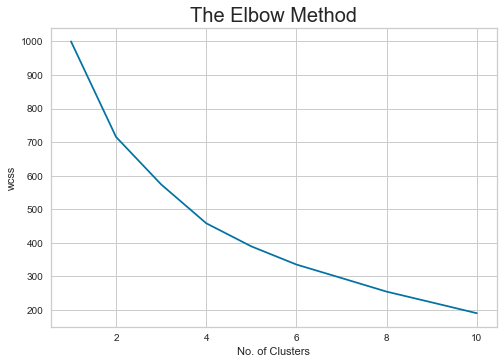

In [86]:
wcss = []

# Scaling data
X_std = StandardScaler().fit_transform(df)

# find number of clusters
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 500, n_init = 10, random_state = 123)
    km.fit(X_std)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

In [87]:
kl = KneeLocator( range(1, 11), wcss, curve="convex", direction="decreasing" )
print("The best k=",kl.elbow)

The best k= 4


#### quick look at pairs of variables with scatter plot : Spending score and annual income make a perfect pair for clustering. 

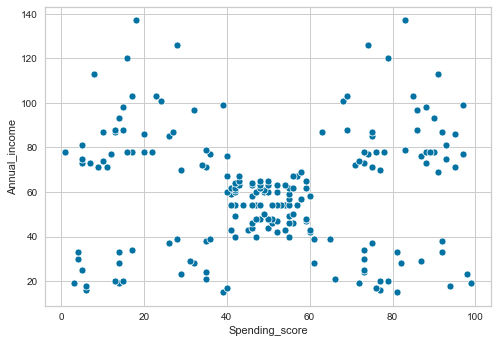

In [88]:
g =sns.scatterplot(x="Spending_score", y="Annual_income", data=df)   
                  

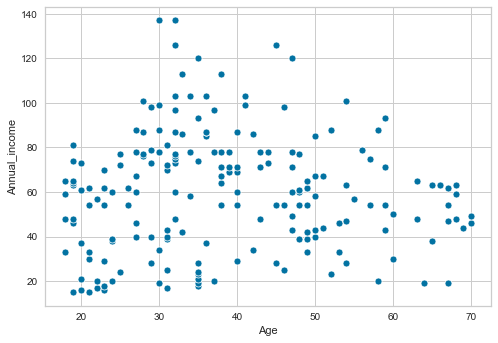

In [89]:
g =sns.scatterplot(x="Age", y="Annual_income", data=df)

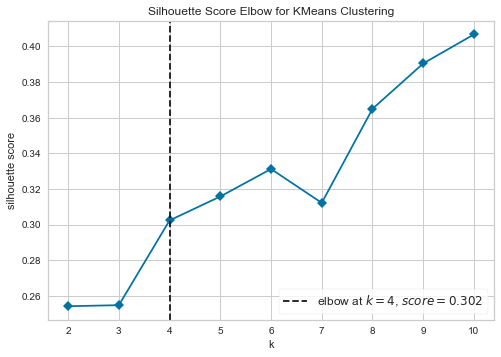

In [90]:
# Import the KElbowVisualizer method   # https://blog.floydhub.com/introduction-to-k-means-clustering-in-python-with-scikit-learn/
from yellowbrick.cluster import KElbowVisualizer   # conda install -c districtdatalabs yellowbrick

# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=456)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,11), metric='silhouette', timings=False)

# Fit the data and visualize
visualizer.fit(X_std)    
#visualizer.poof()  
visualizer.show() 

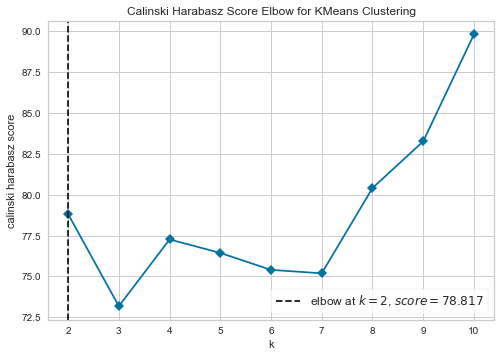

In [91]:
# Instantiate the clustering model and visualizer 
model = KMeans(random_state=789)
visualizer = KElbowVisualizer(model, k=(2,11), metric='calinski_harabasz', timings=False)

visualizer.fit(X_std)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### The silhouette score is the mean silhouette coefficient for all samples, 
### while the calinski_harabasz score computes the ratio of dispersion between and within clusters

### Update K-Means Clustering

In [92]:
# create clustering model with optimal k=5
updated_kmeans_model = KMeans(n_clusters = 5, init='k-means++', max_iter=500, n_init=10, random_state=123)

updated_kmeans_model.fit_predict(X_std)
#data['Cluster'] =(updated_kmeans_model.labels_).astype(str)

# add Cluster number back to the orignal data
ClusterDataset = pd.DataFrame(data=updated_kmeans_model.labels_)
dfClustered = pd.concat([data, ClusterDataset], axis=1)
dfClustered.rename(columns={0:'Cluster'}, inplace=True)


dfClustered.head()

,CustomerID,Gender,Age,Annual_income,Spending_score,Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,4
2,3,Female,20,16,6,4
3,4,Female,23,16,77,4
4,5,Female,31,17,40,4


In [93]:
dfClustered.iloc[:,1:].groupby(['Cluster']).mean()

,Age,Annual_income,Spending_score
Cluster,,,
0,32.550000,86.050000,81.475000
1,56.724138,48.068966,39.724138
2,39.891892,87.432432,18.837838
3,49.463415,48.780488,41.658537
4,24.886792,38.509434,60.830189


Result:

    Cluster 0 : High annual income, high spending (young age wealthy customer)
    Cluster 1 : Medium annual income, medium spending (old age target customer)
    Cluster 2 : High annual income, low spending (miser)
    Cluster 3 : Medium annual income, medium spending (young age target customer)    
    Cluster 4 : Low annual income, high spending (young age spendthrift)

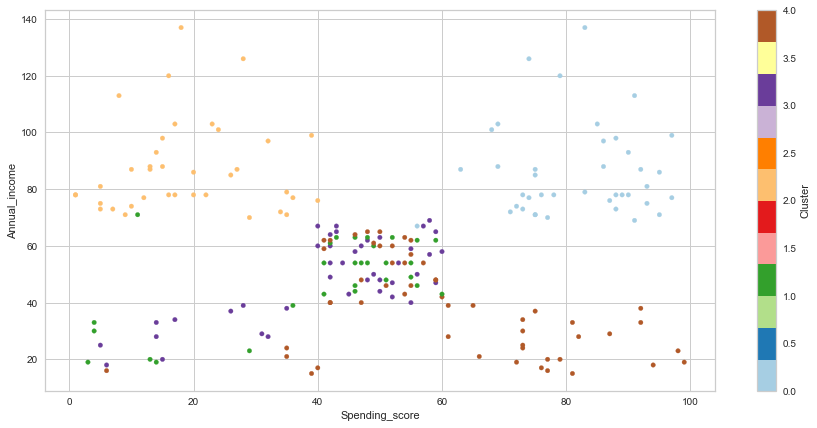

In [94]:
fig, ax = plt.subplots()
dfClustered.plot.scatter(x='Spending_score', y='Annual_income', c='Cluster', figsize=(15,7), cmap="Paired", ax=ax)

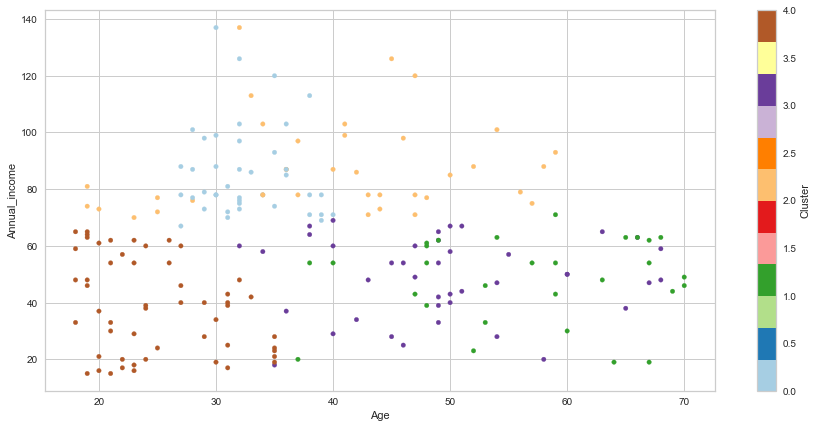

In [95]:
fig, ax = plt.subplots()
dfClustered.plot.scatter(x='Age', y='Annual_income', c='Cluster', cmap="Paired", figsize=(15,7), ax=ax)

### Reference:


https://github.com/EmirKorkutUnal/A-Comparison-of-Clustering-Algorithms-K-means-MeanShift-DBSCAN-in-Python

https://medium.com/pursuitnotes/k-means-clustering-model-in-6-steps-with-python-35b532cfa8ad


### Density-based spatial clustering of applications with noise (DBSCAN) Algorithm

https://github.com/EmirKorkutUnal/A-Comparison-of-Clustering-Algorithms-K-means-MeanShift-DBSCAN-in-Python

DBSCAN creates clusters in a different way than K-means. "min_samples=" allows you to specify a minimum cluster size, and "eps=" is the maximum distance between two obsertavions for them to be considered within the same cluster. This approach allows a more flexible clustering operation, giving control from algorithm to the analyst. Based on these 2 inputs, DBSCAN can also identify some observations as outliers and not include them in any cluster. These observations are labeled with a cluster number of "-1".

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

The model’s behaviour is dictated by several parameters. 
    eps: Two points are considered neighbors if the distance between the two points is below the threshold epsilon.
    min_samples: The minimum number of neighbors a given point should have in order to be classified as a core point. It’s important to note that the point itself is included in the minimum number of samples.
    metric: The metric to use when calculating distance between instances in a feature array (i.e. euclidean distance).

https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

Minimum Samples (“MinPts”)

There is no automatic way to determine the MinPts value for DBSCAN. Ultimately, the MinPts value should be set using domain knowledge and familiarity with the data set. From some research I’ve done, here are a few rules of thumb for selecting the MinPts value:

    The larger the data set, the larger the value of MinPts should be
    If the data set is noisier, choose a larger value of MinPts
    Generally, MinPts should be greater than or equal to the dimensionality of the data set
    For 2-dimensional data, use DBSCAN’s default value of MinPts = 4 (Ester et al., 1996).
    If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).
    
Epsilon (ε)

After you select your MinPts value, you can move on to determining ε. One technique to automatically determine the optimal ε value is described in this paper. This technique calculates the average distance between each point and its k nearest neighbors, where k = the MinPts value you selected. The average k-distances are then plotted in ascending order on a k-distance graph. You’ll find the optimal value for ε at the point of maximum curvature (i.e. where the graph has the greatest slope).

In [96]:
# https://thinkingneuron.com/how-to-create-clusters-using-dbscan-in-python/

# Defining the list of hyperparameters to try
eps_list=np.arange(start=0.1, stop=2, step=0.01)
min_sample_list=np.arange(start=2, stop=20, step=1)
 
# Creating empty data frame to store the silhouette scores for each trials
colnames=["scores", "parameters"]
silhouette_scores_data=pd.DataFrame(columns = colnames)
 
for eps_trial in eps_list:
    for min_sample_trial in min_sample_list:
        
        # Generating DBSAN clusters
        db = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        
        if(len(np.unique(db.fit_predict(X_std)))>1):
            sil_score=silhouette_score(X_std, db.fit_predict(X_std))
        else:
            continue
        trial_parameters="eps:" + str(eps_trial.round(2)) +"; min_sample :" + str(min_sample_trial)

        silhouette_scores_data=silhouette_scores_data.append({'scores':sil_score,'parameters':trial_parameters}, ignore_index=True )
      
# Finding out the best hyperparameters with highest Score
silhouette_scores_data.sort_values(by=['scores'], ascending=False).head(1)

,scores,parameters
378,0.252322,eps:0.73; min_sample :2


In [97]:
# another way
# https://365datascience.com/question/hyper-parameter-tuning-in-dbscan-clustering/

range_min = [x for x in range(2, 21, 1)]
range_eps = [x / 100.0 for x in range(1, 200, 1)] 
dic = {}
for m in range_min:

    for e in range_eps:

        model_1 = DBSCAN(eps = e, min_samples = m).fit(X_std)

        core_samples_mask = np.zeros_like(model_1.labels_, dtype = bool)

        core_samples_mask[model_1.core_sample_indices_] = True

        labels = model_1.labels_

        if len( set(labels) ) > 1:

            silhouette_Avg = silhouette_score(X_std, labels)

            if silhouette_Avg > 0:

                dic[str(m) + " - " + str(e)] = silhouette_Avg

                #print("min-sample value is: " + str(m) + " eps value is: " + str(e) , "The avearge silhouette_score is :",                               silhouette_Avg)
 
max_key = max(dic, key = dic.get)
print("parameter values are: ", max_key)
print("maximum silhouette score value is: ", dic[max_key])

parameter values are:  2 - 0.73
maximum silhouette score value is:  0.25232153670932733


Text(0, 0.5, 'Distance')

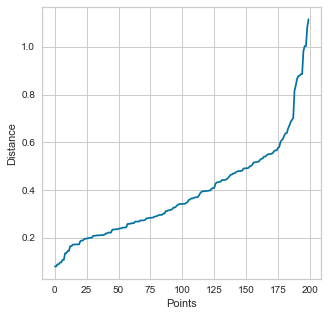

In [98]:
# https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62
# Using Nearest Neighbors method to find eps
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(X_std)
distances, indices = neighbors.kneighbors(X_std)
distances = np.sort(distances[:,1], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
#plt.savefig("Distance_curve.png", dpi=300)

0.5548229882938144


<Figure size 360x360 with 0 Axes>

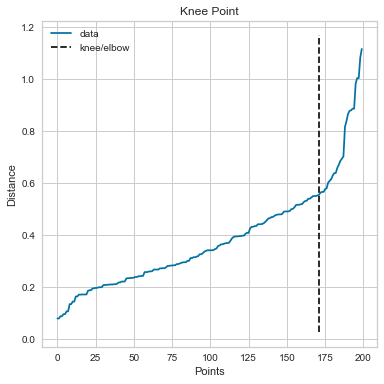

In [99]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [100]:
updated_dbscan_model = DBSCAN(eps=0.55, min_samples=6)
updated_dbscan_model.fit_predict(X_std)
labels = updated_dbscan_model.labels_

#### https://stackoverflow.com/questions/61233304/clustering-with-dbscan-how-to-train-a-model-if-you-dont-set-the-number-of-clust
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_std, labels))

Estimated number of clusters: 4
Estimated number of noise points: 152
Silhouette Coefficient: -0.116


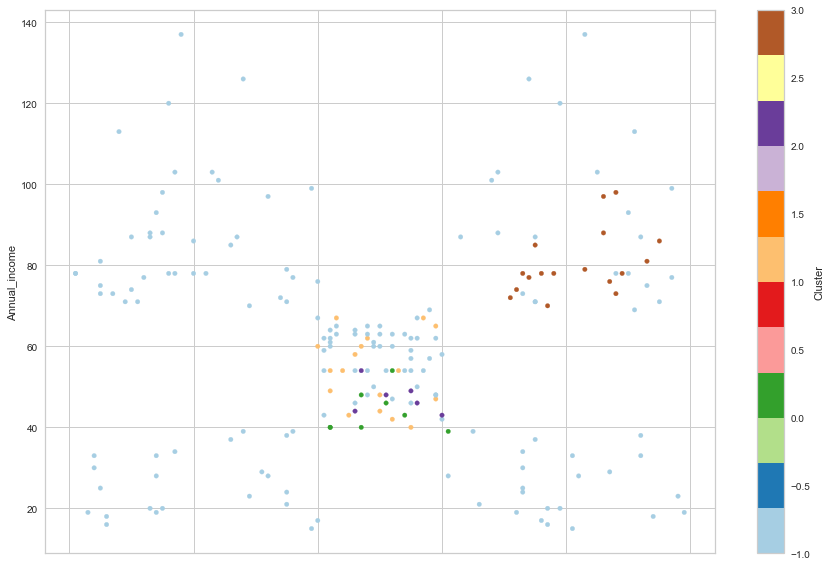

In [101]:
ClusterDataset = pd.DataFrame(data=updated_dbscan_model.labels_)
dfClustered2 = pd.concat([data, ClusterDataset], axis=1)
dfClustered2.rename(columns={0:'Cluster'}, inplace=True)
dfClustered2.plot.scatter(x='Spending_score', y='Annual_income', c='Cluster', cmap="Paired", figsize=(15,10))

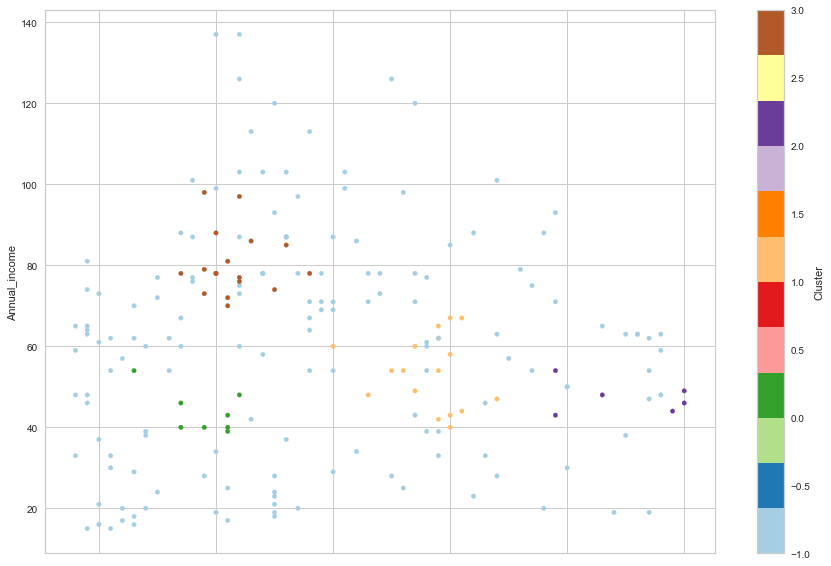

In [102]:
dfClustered2.plot.scatter(x='Age', y='Annual_income', c='Cluster', cmap="Paired", figsize=(15,10))

In [103]:
dfClustered2.head()

,CustomerID,Gender,Age,Annual_income,Spending_score,Cluster
0,1,Male,19,15,39,-1
1,2,Male,21,15,81,-1
2,3,Female,20,16,6,-1
3,4,Female,23,16,77,-1
4,5,Female,31,17,40,-1


In [104]:
dfClustered2.iloc[:,1:].groupby(['Cluster']).mean()

,Age,Annual_income,Spending_score
Cluster,,,
-1,38.118421,60.500000,46.750000
0,28.875000,43.750000,49.500000
1,48.235294,53.764706,48.941176
2,65.000000,47.333333,52.500000
3,31.470588,80.470588,81.823529


#### Cluster = -1 is outliers

### Reference

https://www.geeksforgeeks.org/difference-between-k-means-and-dbscan-clustering/

https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289

https://www.kaggle.com/mandypham/mall-customer-segmentation

https://towardsdatascience.com/mall-customers-segmentation-using-machine-learning-274ddf5575d5

https://towardsdatascience.com/customer-segmentation-using-k-means-clustering-d33964f238c3

https://datauab.github.io/mall_segmentation/

https://medium.com/analytics-vidhya/mall-customers-cluster-analysis-b2ece6effdaa

https://stackoverflow.com/questions/65475105/clustering-scaled-3d-data-with-dbscan-best-eps-value-mall-customer-segmentati

https://www.kaggle.com/datark1/customers-clustering-k-means-dbscan-and-ap